## А/В-тестирование

В ходе тестирования гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, <br>
у контрольной группы оставалась базовая механика. <br>
Проанализируем итоги эксперимента и определим, стоит ли запускать новую механику оплаты на всех пользователей.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import statsmodels as sm
import requests
from urllib.parse import urlencode

1.2 Импортируем файлы с данными

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 

# файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе 
# (А – контроль, B – целевая группа)
public_key_groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
final_url_groups = base_url + urlencode(dict(public_key=public_key_groups)) 
groups = pd.read_csv(requests.get(final_url_groups).json()['href'], sep=';')

# дополнительный файл с пользователями, который прислали спустя 2 дня после передачи данных
public_key_group_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
final_url_group_add = base_url + urlencode(dict(public_key=public_key_group_add)) 
group_add = pd.read_csv(requests.get(final_url_group_add).json()['href'])

# файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
public_key_active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
final_url_active_studs = base_url + urlencode(dict(public_key=public_key_active_studs)) 
active_studs = pd.read_csv(requests.get(final_url_active_studs).json()['href'], sep=';')

# файл с информацией об оплатах пользователей в дни проведения эксперимента.
public_key_checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
final_url_checks = base_url + urlencode(dict(public_key=public_key_checks)) 
checks = pd.read_csv(requests.get(final_url_checks).json()['href'], sep=';')

### Для анализа я сначала буду использовать следующую метрику: конверсию из посетителя в покупателя
Я выбрала эту метрику, поскольку до страницы оплаты добираются пользователи, которые уже выбрали товар и хотят его оплатить.
Соответственно у них есть выбор - оплатить выбранный товар или нет.
По этой логике, если новая механика оплаты более удобная и подходит большему количеству посетителей, то
конверсия в покупку должна вырасти. Если нет, то остаться на прежнем уровне или даже снизиться.

## Предварительный анализ данных

In [77]:
# узнаем количество строк в исходных таблицах
groups.shape[0]

74484

In [8]:
group_add.shape[0]

92

In [9]:
active_studs.shape[0]

8341

In [10]:
checks.shape[0]

541

In [11]:
# проверим данные на наличие пропусков
groups.isnull().sum()

id     0
grp    0
dtype: int64

In [12]:
group_add.isnull().sum()

id     0
grp    0
dtype: int64

In [13]:
active_studs.isnull().sum()

student_id    0
dtype: int64

In [14]:
checks.isnull().sum()

student_id    0
rev           0
dtype: int64

In [15]:
# объединим два датафрэйма (полученный первым и два дня спустя. Будем исходить из предположения,
# что хоть они и были присланы в разные дни, но сбор данных для обоих файлов осуществлялся одновременно, в один период)
all_users = pd.concat([groups, group_add], ignore_index=True)
all_users

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


In [16]:
# переименуем колонку id в student_id
all_users.rename(columns={'id':'student_id'}, inplace=True)
all_users.head()

,student_id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [17]:
# объединим два датафрэйма, чтобы узнать в какие экспериметальные группы попали пользователи
active_studs_ab = active_studs.merge(all_users, how='inner', on='student_id')
active_studs_ab

,student_id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B
...,...,...
8336,1794344,B
8337,296883,B
8338,3598448,B
8339,3610547,B


In [18]:
# проверим, все ли id пользователей уникальны. Видим, что все (т.е. каждый пользователь встречается в датафрэйме 1 раз)
active_studs_ab['student_id'].nunique()

8341

In [19]:
#  в датафрэйме с данными об оплатах проверим, все ли id пользователей уникальны.
# видим, что все.
# то есть каждому id соответствует одна сумма покупки, то есть каждый пользователь совершил только одну оплату
checks['student_id'].nunique()

541

In [20]:
# посмотрим количественное распределение активных пользователей по группам
# Видим, что количество пользователей в целевой группе более чем в 4 раза превышает количество в контрольной группе.
active_studs_ab.groupby('grp').agg({'student_id':'nunique'})

,student_id
grp,
A,1538
B,6803


In [21]:
# объединим полученную таблицу с данными о суммах покупок. 
active_studs_ab_rev = active_studs_ab.merge(checks, on='student_id', how='left')
active_studs_ab_rev

,student_id,grp,rev
0,581585,A,NaN
1,5723133,A,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN
...,...,...,...
8336,1794344,B,NaN
8337,296883,B,NaN
8338,3598448,B,NaN
8339,3610547,B,290.0


In [23]:
# заменим NAN на 0 в тех строках, где пользователь не сделал покупок
active_studs_ab_rev['rev'] = active_studs_ab_rev['rev'].fillna(0)
active_studs_ab_rev.head()

,student_id,grp,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0
3,4238589,A,0.0
4,4475369,B,0.0


In [24]:
# проверим, какие типы данных получились в результирующем датафрэйме
active_studs_ab_rev.dtypes

student_id      int64
grp            object
rev           float64
dtype: object

In [25]:
# добавим в результирующий датафрэйм еще один столбец, где будет один из двух вариантов - 
# была пользователем сделана покупка (sale) или нет (no_sale).
active_studs_ab_rev['sale_yes_or_no']=['no_sale' if x==0 else 'sale' for x in active_studs_ab_rev['rev']]

In [26]:
active_studs_ab_rev.head()

,student_id,grp,rev,sale_yes_or_no
0,581585,A,0.0,no_sale
1,5723133,A,0.0,no_sale
2,3276743,B,0.0,no_sale
3,4238589,A,0.0,no_sale
4,4475369,B,0.0,no_sale


In [27]:
# отберем в датафрэйм а  всех пользователей из контрольной группы
a = active_studs_ab_rev.query('grp=="A"')
a

,student_id,grp,rev,sale_yes_or_no
0,581585,A,0.0,no_sale
1,5723133,A,0.0,no_sale
3,4238589,A,0.0,no_sale
7,1394612,A,0.0,no_sale
21,5194768,A,0.0,no_sale
...,...,...,...,...
8317,3208984,A,0.0,no_sale
8320,2900558,A,0.0,no_sale
8326,1161774,A,0.0,no_sale
8330,5006972,A,0.0,no_sale


In [28]:
# отберем в датафрэйм b  всех пользователей из целевой (тестовой) группы
b = active_studs_ab_rev.query('grp=="B"')
b

,student_id,grp,rev,sale_yes_or_no
2,3276743,B,0.0,no_sale
4,4475369,B,0.0,no_sale
5,5481015,B,0.0,no_sale
6,1353433,B,0.0,no_sale
8,1170611,B,0.0,no_sale
...,...,...,...,...
8336,1794344,B,0.0,no_sale
8337,296883,B,0.0,no_sale
8338,3598448,B,0.0,no_sale
8339,3610547,B,290.0,sale


In [29]:
# посчитаем количество пользователей в контрольной группе, которые совершили покупку
a.query('rev!=0').student_id.count()

78

In [30]:
# посчитаем общее количество пользователей в контрольной группе
a.student_id.count()

1538

In [31]:
# посчитаем конверсию из посетителей в покупатели в контрольной группе.

78/1538

0.05071521456436931

In [32]:
# посчитаем количество пользователей в тестовой группе, которые совершили покупку
b.query('rev!=0').student_id.count()

314

In [33]:
# посчитаем конверсию из посетителей в покупатели в тестовой группе.
b.student_id.count()

6803

In [34]:
# посчитаем конверсию из посетителей в покупатели в тестовой группе.

314/6803

0.046156107599588415

### получили, что конверсия из посещения в покупку с новой механикой оплаты услуг уменьшилась на 0,46% по сравнению с базовой

In [35]:
# проверим этот результат на статистическую значимость. Для этого используем таблицу сопряженности и критерий хи квардат.
# за нулевую гипотезу примем предположение, что распределения признака (купил/не купил) в группах А и В одинаковы.

#Проверим соблюдение необходимых условий для применения этого критерия:

# данные являются категориальными
# количество наблюдений в каждой ячейке таблицы сопряженности не меньше 5
# наблюдения являются независимыми (предполагаем, что по условиям эксперимента это было так)
# имеется достаточное количество наблюдений для проведения анализа.

# Все условия соблюдены

In [36]:
# построим таблицу сопряженности
active_studs_ab_rev_cross = pd.crosstab(active_studs_ab_rev.sale_yes_or_no, active_studs_ab_rev.grp)
active_studs_ab_rev_cross

grp,A,B
sale_yes_or_no,,
no_sale,1460,6489
sale,78,314


In [37]:
from scipy.stats import chi2_contingency, chi2

In [38]:
stat, p, dof, expected = chi2_contingency(active_studs_ab_rev_cross)

In [39]:
stat, p

(0.48480826522557896, 0.48625240457231045)

значение критерия намного меньше 12, а P-value оказался значительно больше, чем 0.05, <br>
следовательно мы не можем отклонить нулевую гипотезу о том, что количество покупок в тестовой группе не отличается от их количества в контрольной группе.
### в результате исследования мы обнаружили, что при использовании новой механики оплаты не произошло статистически значимого изменения конверсии посещений в покупки.

Предположим, что новая механика оплаты могла повлиять не только на факт, сделана покупка или нет, но и на сумму покупки. К примеру, при большой сумме покупки на странице оплаты предоставляется дополнительная скидка. <br>
Проверим это предположение с помощью метрики ARPU.

In [40]:
# посчитаем, какой ARPU получился в обеих группах.
# чтобы найти ARPU, общую сумму покупок в каждой группе разделим на количество пользователей в этой группе
a['rev'].sum()/1538

47.34720416124838

In [41]:
b['rev'].sum()/6803

58.05879810377775

Видим, что ARPU в тестовой группе больше примерно на 23%, чем в контрольной группе. Проверим статистическую значимость этих различий.

In [42]:
# для удобства исследования, чтобы не мешало большое количество данных с нулевой суммой платежа,
# будем сравнивать не APRU, а ARPPU, то есть только те строки, где была совершена покупка
# мы можем так сделать, потому что ранее убедились в том, что конверсии в покупку в обеих группах
# статистически значимо не различаются
a_sales = a.query('rev!=0').rev.to_frame()
a_sales.head()

,rev
62,1530.0
99,1980.0
306,580.0
392,2910.0
439,690.0


/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


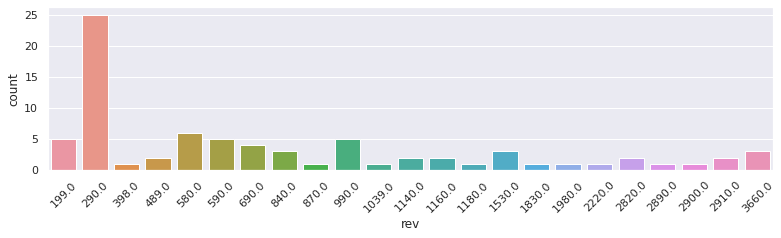

In [44]:
# построим countplot, чтобы посмотреть распределение сумм оплат в контрольной группе
sns.set(rc={"figure.figsize":(13,3)})
plt.xticks(rotation=45)
sns.countplot(a_sales.query('rev!=0').rev)

In [45]:
# по графику видно, что распределение мало похоже на нормальное. 
# но на всякий случай проверим его на нормальность с помощью теста Шапиро-Уилка
from scipy.stats import shapiro

In [46]:
stat, p = shapiro(a_sales.rev)

In [47]:
print ('Статистика теста:', stat)
print ('p-значение:', p)

Статистика теста: 0.7353236079216003
p-значение: 1.4986822893803264e-10


как видно из результатов теста, p-значение намного меньше, чем 0.05, следовательно данные не распределены нормально

In [49]:
# теперь проверим на нормальность распределение сумм покупок в тестовой группе
b_sales = b.query('rev!=0').rev.to_frame()
b_sales

,rev
67,1900.0001
77,1900.0000
193,1900.0000
195,1900.0000
211,1900.0000
...,...
8109,1900.0001
8191,1900.0000
8201,199.0000
8277,597.0000


/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


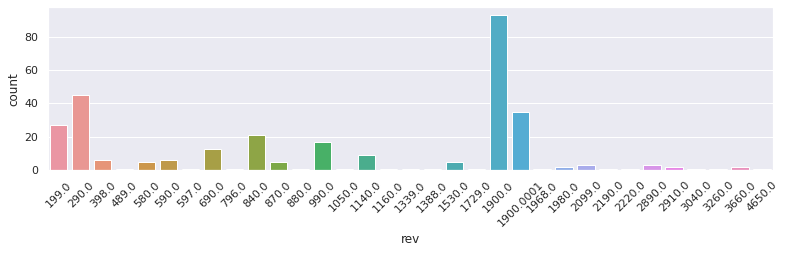

In [50]:
# построим countplot, чтобы посмотреть распределение сумм оплат в тестовой группе
sns.set(rc={"figure.figsize":(13,3)})
plt.xticks(rotation=45)
sns.countplot(b_sales.rev)

In [51]:
stat, p = shapiro(a_sales.rev)

In [52]:
print ('Статистика теста:', stat)
print ('p-значение:', p)

Статистика теста: 0.7353236079216003
p-значение: 1.4986822893803264e-10


в этой группе также p-значение намного меньше, чем 0.05, следовательно данные не распределены нормально

Распределения не являются нормальными, но при этом количество имеющихся данных достаточно велико: <br>
78 - в контрольной группе и 314 в тестовой, <br>
для определения наличия статистически значимых различий между средними двух этих групп применим t-test.

In [53]:
from scipy.stats import ttest_ind

In [54]:
ttest_ind(b_sales.rev,a_sales.rev)

Ttest_indResult(statistic=3.1337795050930985, pvalue=0.0018562025265765867)

p-value меньше, чем 0.05, следовательно существует статистически значимая разница между ARPPU <br>
в тестовой и контрольной группах.

## Аналитическое заключение по результатам анализа:
В результате анализа данных обнаружено следующее: <br>
В группе, где использовалась новая механика оплаты, пользователи сделали тратили статистически больше денег, чем те, которые пользовались старой механикой. Поэтому можно рекомендовать включить новую механику оплаты на всех пользователей.<br><br>
Рекомендация: в дальнейшем доработать систему так, чтобы увеличилась конверсия из посетителя в покупателя (на данный момент у пользователей из групп, использовавших разные механики оплаты, конверсия статистически значимо не различается.)

### Реализуем функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv и на основании дополнительных параметров пересчитывать метрики.<br><br>


In [1]:
# у нас имеется три файла: groups.csv, active_studs.csv и checks.csv
# требуется реализовать функцию, которая будет подгружать дополнительный 4-ый файл group_add.csv 
#(он может называться и по-другому)
# и на основе данных этих 4-х файлов функция должна расчитывать значения метрик, которые были расчитаны выше:
# конверсию в покупку, ARPU, ARPPU для тестовой и контрольной групп.

In [57]:
def recount(path_to_file):

    #base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    #public_key_group_add = path_to_file
    #final_url_group_add = base_url + urlencode(dict(public_key=public_key_group_add)) 
    #group_add = pd.read_csv(requests.get(final_url_group_add).json()['href'], sep=';')
    
    group_add = pd.read_csv(path_to_file, sep=',')
    all_users = pd.concat([groups, group_add], ignore_index=True)
    all_users.rename(columns={'id':'student_id'}, inplace=True)
    active_studs_ab = active_studs.merge(all_users, how='inner', on='student_id')
    active_studs_ab_rev = active_studs_ab.merge(checks, on='student_id', how='left')
    active_studs_ab_rev['rev'] = active_studs_ab_rev['rev'].fillna(0)
    active_studs_ab_rev['sale_yes_or_no']=['no_sale' if x==0 else 'sale' for x in active_studs_ab_rev['rev']]
    print("МЕТРИКИ:")
    number_of_sales_in_A_group = active_studs_ab_rev.query('grp=="A" & sale_yes_or_no=="sale"').agg({'student_id':'count'}).to_frame().iloc[0][0]
    number_of_users_in_A_group = active_studs_ab_rev.query('grp=="A"').agg({'student_id':'count'}).to_frame().iloc[0][0]
    CR_A_group = number_of_sales_in_A_group/number_of_users_in_A_group
    print ('Конверсия в покупку в контрольной группе', CR_A_group)
    number_of_sales_in_B_group = active_studs_ab_rev.query('grp=="B" & sale_yes_or_no=="sale"').agg({'student_id':'count'}).to_frame().iloc[0][0]
    number_of_users_in_B_group = active_studs_ab_rev.query('grp=="B"').agg({'student_id':'count'}).to_frame().iloc[0][0]
    CR_B_group = number_of_sales_in_B_group/number_of_users_in_B_group
    print ('Конверсия в покупку в тестовой группе', CR_B_group)
    total_revenue_in_A_group = active_studs_ab_rev.query('grp=="A"')['rev'].sum()
    number_of_students_in_A_group = active_studs_ab_rev.query('grp=="A"')['student_id'].count()
    ARPU_in_A_group = total_revenue_in_A_group/number_of_students_in_A_group
    print("ARPU в контрольной группе", ARPU_in_A_group)
    total_revenue_in_B_group = active_studs_ab_rev.query('grp=="B"')['rev'].sum()
    number_of_students_in_B_group = active_studs_ab_rev.query('grp=="B"')['student_id'].count()
    ARPU_in_B_group = total_revenue_in_B_group/number_of_students_in_B_group
    print("ARPU в тестовой группе", ARPU_in_B_group)
    number_of_paying_students_in_A_group = active_studs_ab_rev.query('grp=="A" & rev!=0')['student_id'].count()
    ARPPU_in_A_group = total_revenue_in_A_group/number_of_paying_students_in_A_group
    print("ARPPU в контрольной группе", ARPPU_in_A_group)
    number_of_paying_students_in_B_group = active_studs_ab_rev.query('grp=="B" & rev!=0')['student_id'].count()
    ARPPU_in_B_group = total_revenue_in_B_group/number_of_paying_students_in_B_group
    print("ARPPU в тестовой группе", ARPPU_in_B_group)
    
    
    return [CR_A_group, CR_B_group, ARPU_in_A_group, ARPU_in_B_group, ARPPU_in_A_group, ARPPU_in_B_group]

In [59]:
# демонстрация работы функции (в качестве аргумента подается адрес расположения дополнительного файла с данными,
# заключенный в кавычки):
x = recount('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')
x

МЕТРИКИ:
Конверсия в покупку в контрольной группе 0.050814332247557006
Конверсия в покупку в тестовой группе 0.04607684380980421
ARPU в контрольной группе 47.43973941368078
ARPU в тестовой группе 57.86456698071544
ARPPU в контрольной группе 933.5897435897435
ARPPU в тестовой группе 1255.8274872204472


[0.050814332247557006,
 0.04607684380980421,
 47.43973941368078,
 57.86456698071544,
 933.5897435897435,
 1255.8274872204472]

### Теперь реализуем функцию, которая будет строить графики по получаемым метрикам

In [75]:
# в качестве аргумента функции передаем результат работы предыдущей функции recount: список из посчитанных метрик
def visual(arg):
    
    # создаем датафрэйм со значениями конверсии в контрольной и тестовой группах - помещаем в него два первых элемента списка
    CR_metrics = pd.DataFrame([[arg[0], arg[1]]], columns=['Контр. группа', 'Тест. группа'])
    
    # создаем датафрэйм со значениями ARPU в контрольной и тестовой группах - помещаем в него два следующих элемента списка
    ARPU_metrics = pd.DataFrame([[arg[2], arg[3]]], columns=['Контр. группа', 'Тест. группа'])
    
    # создаем датафрэйм со значениями ARPPU в контрольной и тестовой группах - помещаем в него два следующих элемента списка
    ARPPU_metrics = pd.DataFrame([[arg[4], arg[5]]], columns=['Контр. группа', 'Тест. группа'])
    
    # Для того, чтобы расположить несколько графиков на одном листе, используем plt.subplots
    fig, axes = plt.subplots(1,3, constrained_layout=True)
    plt.suptitle('Сравнительные результаты по метрикам контрольной и тестовой группы')
    
    #строим три барплота для трех метрик, на которых наглядно видна разница между значениями для
    # контрольной и тестовой групп
    sns.barplot(data=CR_metrics, ax=axes[0])
    axes[0].set_title("Конверсия в продажу")
    sns.barplot(data=ARPU_metrics, ax=axes[1])
    axes[1].set_title("ARPU")    
    sns.barplot(data=ARPPU_metrics, ax=axes[2])
    axes[2].set_title("ARPPU")

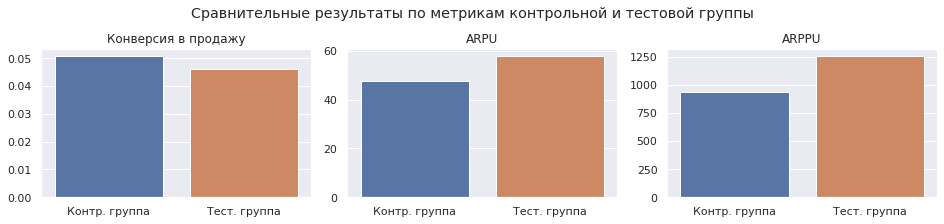

In [76]:
# демонстрация работы функции (в переменную x записан результат работы функции из предыдущего задания)
visual(x)